In [1]:
##### Yilin YE @ Mar. 2022
##### EHD + Brownian motion
##### Based on 1412.0162

##### Here is a file based on the technique shown in the article 
##### J. Phys. Chem. B 2014, 118, 6466−6474
##### See ""Support Information"" for the Multi-dimensional case

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
##### Define parameters/constants

## time scale
Nmax = 10000 ## Define the maximum of steps
dt = 1e-13 ## Define the time gap ∆t (s) for each step

## enviroment
T = 298 # temperature (K)
k_B = 1.38064852*10e-23 # Boltzmann constant
beta = 1/(k_B*T)

## mass & effective mass on each direction

rayon = 1.5e-6 # 1µm = 10^{-6}m, with unit of meter
rhosty = 1.06e3 # density of polystyrene, kg/m3
rhosol = 1.00e3 # density of solvent, kg/m3
mass = 4/3*3.1415926*rayon**3*rhosty # mass of the column, with unit of kg
mz = mass
mx = mass
mt = mass*rayon**2/2

m = np.zeros(3)
m[0] = mz
m[1] = mx
m[2] = mt
grav = 9.80665 # Gravitational acceleration, with unit of m/s^2

## solvent property
kappa = 1e-4*0 ## compliance, 10^{-4} ~ 10 ^{-3}
eps = 0.1 ## arbitrary value temporarily
xi = 1 ## arbitrary value temporarily
kxi = kappa*xi
kxe = kappa*xi*eps

## relevant coefficients
coefa = np.zeros(7)
coefb = np.zeros(7)
coefc = np.zeros(7)

coefa[1] = xi
coefa[2] = 21*kxi/4
coefa[3] = -kxi/4
coefa[4] = kxi/2
coefa[5] = -15*kxi/8
coefa[6] = 1

coefb[1] = 2*eps*xi/3
coefb[2] = 19*kxe/24
coefb[3] = -kxe/6
coefb[4] = kxe/12
coefb[5] = -kxe/12
coefb[6] = 0

coefc=coefb*2

In [4]:
def _gammavalue(i,j,z,vz,vx,vt):
    """
    This function would furnish the value of gamma matrix
    i,j: matrix index
    kappa,eps,xi: constant/parameters
    z: vertical position
    vz,vx,vt: velocity vector
    """
    zroot = np.sqrt(z)
    
    if (i==0)and(j==0):
        return xi/zroot**3 + ((15*xi)/(8*z**5) + (21*vz)/(4*zroot**9))*kappa*xi
    if (i==1)and(j==1):
        return (2*eps*xi)/(3*zroot) + (4*zroot*eps**2*xi+18*vz+57*eps*vt)*kappa*xi/(72*zroot**7)
    if (i==2)and(j==2):
        return (4*eps*xi)/(3*zroot) + ((2*eps**2*xi)/(9*z**3) + ((3+19*eps)*vz)/(12*zroot**7))*kappa*xi
    if (i+j==1):
        return xi*kappa*((3+eps)*vt-3*vx)/(12*zroot**7)
    if (i+j==2)and(i*j==0):
        return xi*kappa*((3-eps)*vx-3*vt)/(12*zroot**7)
    if (i+j==3):
        return ((eps**2*xi)/(9*z**3) - ((1+eps)*vz)/(4*zroot**7))*kappa*xi


In [5]:
def _forcevalue(i,z,vz,vx,vt):
    """
    This function would furnish the force on each direction
    i: index, refers to z/x/t(theta)
    z: vertical position
    vz,vx,vt: velocity vector
    """
    zroot = np.sqrt(z)
    if (i==0):
        return -mz*(coefa[1]*vz/(zroot**3)+
                    coefa[2]*vz**2/(zroot*9)+
                    coefa[3]*(vx**2+vt**2)/(zroot**7)+
                    coefa[4]*vx*vt/(zroot**7)+
                    coefa[6])*0 - grav*mz*(rhosty-rhosol*1)
    if (i==1):
        return -mx*(coefb[1]*vx/zroot+
                    coefb[2]*vz*vx/(zroot**7)+
                    coefb[3]*vz*vt/(zroot**7)+
                    coefb[6])*0
    if (i==2):
        return -mt*(coefc[1]*vt/zroot+
                    coefc[2]*vz*vt/(zroot**7)+
                    coefc[3]*vz*vx/(zroot**7)+
                    coefc[6])*0

In [6]:
def _Minverse(i,j,z):
    """
    This function would furnish the inverse M
    i,j: index; z: vertical distance
    """
    zroot = np.sqrt(z)
    if (i+j==0):
        return 1/mz * (1 + (15*kxi)/(8*zroot**5))
    if (i*j==1):
        return 1/mx * (1 + kxe/(12*zroot**5))
    if (i==1)and(j==2):
        return -kxe/(12*zroot**5*mt)
    if (i==2)and(j==1):
        return -kxe/(6*zroot**5*mx)
    if (i+j==4):
        return 1/mt * (1 + kxe/(6*zroot**5))
    if (i*j==0)and(i+j!=0):
        return 0

In [7]:
##### Define position/velocity/force vectors
position = np.zeros((Nmax,3)) ## first index for time step, second index for z/x/t(theta)
velocity = np.zeros((Nmax,3)) ## first index for time step, second index for z/x/t(theta)
force = np.zeros((Nmax,3)) ## first index for time step, second index for z/x/t(theta)

##### Define gamma matrix
gamma = np.zeros((3,3))

##### Define M inverse matrix
Minv = np.zeros((3,3))


In [8]:
def _updategamma(z,vz,vx,vt):
    """
    This procedure would update the value of gamma matrix
    z: vertical position
    vz,vx,vt: velocity on each direction
    """
    for i in range(3):
        for j in range(3):
            gamma[i,j] = _gammavalue(i,j,z,vz,vx,vt)

In [9]:
def _updateforce(indice,z,vz,vx,vt):
    """
    This procedure would update the value of force vector
    indice: refers to the time step
    z: vertical position
    vz,vx,vt: velocity on each direction
    """
    for i in range(3):
        force[indice,i] = _forcevalue(i,z,vz,vx,vt)

In [10]:
def _updateMinverse(z):
    """
    This procedure would update the value of Minverse
    z: vertical position
    """
    for i in range(3):
        for j in range(3):
            Minv[i,j] = _Minverse(i,j,z)

In [11]:
### initial height
position[0,0] = 5e-7 # 0.5µm
#velocity[0,:] = np.random.default_rng().normal(loc=0.0, scale=1.0, size=3)*1e-6 # if kappa=0, no correction about velocity

## gamma matrix initiation
_updategamma(position[0,0],velocity[0,0],velocity[0,1],velocity[0,2])
## force vector initiation
_updateforce(0,position[0,0],velocity[0,0],velocity[0,1],velocity[0,2])
## M inverse matrix initiation
_updateMinverse(position[0,0])

In [12]:
print("Initial gamma matrix = ")
print(gamma)
print("")

print("Initial velocity vector = ")
print(velocity[0,:])
print("")

print("Initial force vector = ")
print(force[0,:])
print("")

print("Initial Minverse matrix = ")
print(Minv)
print("")

Initial gamma matrix = 
[[2.82842712e+09 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.42809042e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88561808e+02]]

Initial velocity vector = 
[0. 0. 0.]

Initial force vector = 
[-8.81739243e-12 -0.00000000e+00 -0.00000000e+00]

Initial Minverse matrix = 
[[ 6.67316335e+13  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  6.67316335e+13 -0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00  5.93170075e+25]]



In [13]:
def _updateintm():
    """
    This procedure would update the values of intma & intmb
    ## a=exp(-gamma*dt)
    ## b=sqrt(2/(gamma*dt)*tanh(gamma*dt/2))
    """
    for i in range(3):
        for j in range(3):
            if (i!=j)and(gamma[i,j]==0):
                intma[i,j] = 0
                intmb[i,j] = 0
            else:
                intma[i,j] = np.exp(-gamma[i,j]*dt)
                gt2=gamma[i,j]*dt/2
                intmb[i,j] = np.sqrt(np.tanh(gt2)/gt2)
            #if (gamma[i,j]==0):
            #    intmb[i,j] = 1 # Consider the limit if gamma->0 to avoid "nan"

In [14]:
##### Define intermediate position/velocity vectors
p12 = np.zeros(3) ## intermediate position (n+1/2)
v14 = np.zeros(3)
v24 = np.zeros(3)
v34 = np.zeros(3) ## intermediate velocity (n+1/4), (n+1/2), (n+3/4)

##### Define intermediate variable a&b related to gamma matrix
intma = np.zeros((3,3))
intmb = np.zeros((3,3))
## intma & intmb initiation
_updateintm()


i = 0

In [15]:
print("intma=")
print(intma)
print("")

print("intmb=")
print(intmb)
print("")

print("np.sqrt((1-intma)@Minv/beta)")
print(np.sqrt((1-intma)@Minv/beta))
print("")

print("np.dot(np.sqrt(intma),velocity[0,:])")
print(np.dot(np.sqrt(intma),velocity[0,:]))
print("")

intma=
[[0.9997172 0.        0.       ]
 [0.        1.        0.       ]
 [0.        0.        1.       ]]

intmb=
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

np.sqrt((1-intma)@Minv/beta)
[[2.78648920e-05 1.65697355e-03 1.56220964e+03]
 [1.65697355e-03 5.08777902e-09 1.56220964e+03]
 [1.65697355e-03 1.65697355e-03 6.78368539e-03]]

np.dot(np.sqrt(intma),velocity[0,:])
[0. 0. 0.]



In [16]:
##### Follow the calculs shown in jp411770f
## v(n+1/4)=sqrt(a)*v(n)+sqrt((1-a)/(beta*m))*N(n)
## v(n+1/2)=v(n+1/4)+b*dt/2*f(n)/m
## r(n+1/2)=r(n)+b*dt/2*v(n+1/2)
## H(n)->H(n+1)
## r(n+1)=r(n+1/2)+b*dt/2*v(n+1/2)
## v(n+3/4)=v(n+1/2)+b*dt/2*f(n+1)/m
## v(n+1)=sqrt(a)*v(n+3/4)+sqrt((1-a)/(beta*m))*N(n+1)



for j in range(Nmax-1):
    # Gauss(0,1) white noise
    grandNp = np.random.default_rng().normal(loc=0.0, scale=1.0, size=3)
    grandNm = np.random.default_rng().normal(loc=0.0, scale=1.0, size=3)
    
    v14 = np.sqrt(intma)@velocity[i,:] + np.sqrt((1-intma)@Minv/beta)@grandNp
    _updategamma(position[i,0],v14[0],v14[1],v14[2])
    _updateintm()
    _updateforce(i,position[i,0],v14[0],v14[1],v14[2])
    ###_updateMinverse(position[i,0])
    
    v24 = v14 + dt/2 * intmb@Minv@force[i,:]
    _updategamma(position[i,0],v24[0],v24[1],v24[2])
    _updateintm()
    ###_updateforce(i,position[i,0],v24[0],v24[1],v24[2])
    ###_updateMinverse(position[i,0])
    
    
    p12 = position[i,:] + dt/2 * intmb@v24
    _updategamma(p12[0],v24[0],v24[1],v24[2])
    _updateintm()
    ###_updateforce(i,p12[0],v24[0],v24[1],v24[2])
    _updateMinverse(p12[0])
    
    ###force[i+1,:] = _forcevalue(i,p12[0],v24[0],v24[1],v24[2])
    #_updateforce(i+1,p12[0],v24[0],v24[1],v24[2])
    
    position[i+1,:] = p12 + dt/2 * intmb@v24
    _updategamma(position[i+1,0],v24[0],v24[1],v24[2])
    _updateintm()
    _updateforce(i+1,position[i+1,0],v24[0],v24[1],v24[2])
    _updateMinverse(position[i+1,0])
    
    v34 = v24 + dt/2 * intmb@Minv@force[i+1,:]
    _updategamma(position[i+1,0],v34[0],v34[1],v34[2])
    _updateintm()
    ###_updateforce(i,p12[0],v24[0],v24[1],v24[2])
    ###_updateMinverse(position[i+1,0])
    
    
    velocity[i+1,:] = np.sqrt(intma)@v34 + np.sqrt((1-intma)@Minv/beta)@grandNm
    _updategamma(position[i+1,0],velocity[i+1,0],velocity[i+1,1],velocity[i+1,2])
    _updateintm()
    ###_updateforce(i,p12[0],v24[0],v24[1],v24[2])
    ###_updateMinverse(position[i+1,0])
    
    i=i+1

In [17]:
print("i=",i)
print("gamma=")
print(gamma)
print("intma=")
print(intma)
print("intmb=")
print(intmb)
print("Minverse=")
print(Minv)

print("np.sqrt(intma)@velocity[i,:]")
print(np.sqrt(intma)@velocity[i,:])
print("")
print("np.sqrt((1-intma)@Minv/beta)@grandNp")
print(np.sqrt((1-intma)@Minv/beta)@grandNp)
print("")

print("")
print("grandNp=",grandNp)
print("grandNm=",grandNm)
print("p12=",p12)
print("v14=",v14)
print("v24=",v24)
print("v34=",v34)

print("")
#print("i=",i)
print("position[i-1,:]=",position[i-1,:])
print("position[i,:] = ",position[i,:])
print("velocity[i-1,:]=",velocity[i-1,:])
print("velocity[i,:] = ",velocity[i,:])
print("force[i-1,:]=",force[i-1,:])
print("force[i,:] = ",force[i,:])

i= 9999
gamma=
[[ 5.37322631e+06 -0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00  1.16767089e+01 -0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00  2.33534177e+01]]
intma=
[[0.99999946 0.         0.        ]
 [0.         1.         0.        ]
 [0.         0.         1.        ]]
intmb=
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Minverse=
[[ 6.67316335e+13  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  6.67316335e+13 -0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00  5.93170075e+25]]
np.sqrt(intma)@velocity[i,:]
[1.15381584e+05 5.32990371e+04 4.10218169e+00]

np.sqrt((1-intma)@Minv/beta)@grandNp
[-6.11159708e+02 -6.11163624e+02 -8.34788687e-05]


grandNp= [-0.92537467  1.43865433 -0.39121644]
grandNm= [ 1.56891767 -0.11587803  0.08451346]
p12= [ 3.25911584e-05 -1.54518615e-05  2.33628230e-09]
v14= [1.15249619e+05 5.31670068e+04 4.09957228e+00]
v24= [1.15249619e+05 5.31670068e+04 4.09957228e+00]
v34= [1.15249619e+05 5.31670068e+04 4.09957228e+00]

position[i-1,:]= [ 3.25853959e-05 -

<function matplotlib.pyplot.show(*args, **kw)>

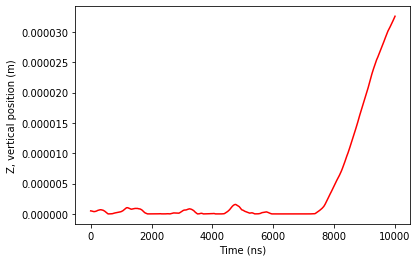

In [18]:
plt.plot(position[:,0],"-",color='red')
plt.xlabel('Time (ns)')
plt.ylabel('Z, vertical position (m)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

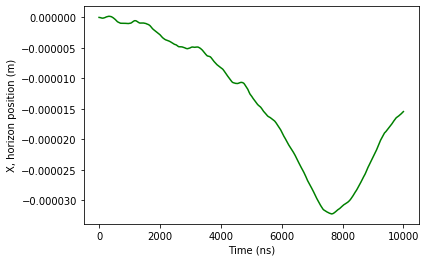

In [19]:
plt.plot(position[:,1],"-",color="green")
plt.xlabel('Time (ns)')
plt.ylabel('X, horizon position (m)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

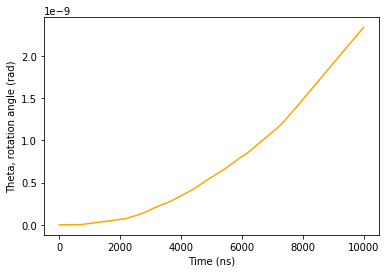

In [20]:
plt.plot(position[:,2],"-",color="orange")
plt.xlabel('Time (ns)')
plt.ylabel('Theta, rotation angle (rad)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

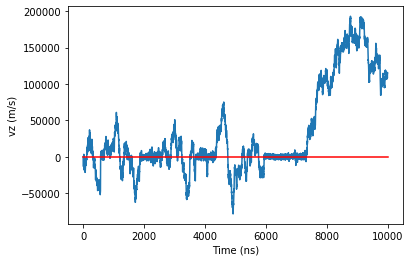

In [21]:
plt.plot(velocity[:,0],"-")
plt.plot([0,Nmax],[0,0],color='red')
plt.xlabel('Time (ns)')
plt.ylabel('vz (m/s)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

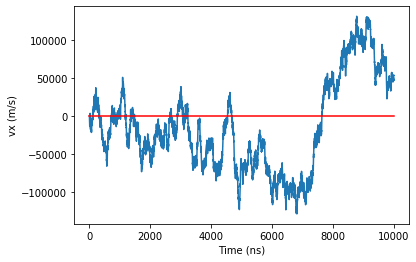

In [22]:
plt.plot(velocity[:,1],"-")
plt.plot([0,Nmax],[0,0],color='red')
plt.xlabel('Time (ns)')
plt.ylabel('vx (m/s)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

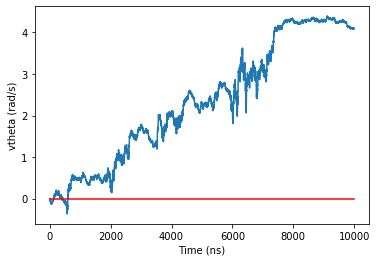

In [23]:
plt.plot(velocity[:,2],"-")
plt.plot([0,Nmax],[0,0],color='red')
plt.xlabel('Time (ns)')
plt.ylabel('vtheta (rad/s)')
plt.show